In [1]:
from itertools import islice

import sqlite3
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

In [2]:
def window(seq, n=2):
    "Returns a sliding window (of width n) over data from the iterable"
    "   s -> (s0,s1,...s[n-1]), (s1,s2,...,sn), ...                   "
    it = iter(seq)
    result = tuple(islice(it, n))
    if len(result) == n:
        yield result
    for elem in it:
        result = result[1:] + (elem,)
        yield result

In [3]:
def normalize_datetime64s(input):
    return (pd.to_numeric(input) - np.min(pd.to_numeric(input))) / 1000000000

## Read in data

In [4]:
conn = sqlite3.connect("star.db")

In [5]:
df = pd.read_sql_query("SELECT * FROM temperature",
                       conn,
                       parse_dates=('recorded_at'))
df_humidity = pd.read_sql_query("SELECT * FROM humidity",
                                conn,
                                parse_dates=('recorded_at'))
df_pressure = pd.read_sql_query("SELECT * FROM pressure",
                                conn,
                                parse_dates=('recorded_at'))
df_battery_voltage = pd.read_sql_query("SELECT * FROM battery_voltage",
                                       conn,
                                       parse_dates=('recorded_at'))

In [6]:
conn.close()

In [7]:
df.recorded_at

0         2021-08-25 21:00:00
1         2021-08-25 21:00:01
2         2021-08-25 21:00:04
3         2021-08-25 21:00:05
4         2021-08-25 21:00:10
                  ...        
2347214   2021-12-01 17:44:47
2347215   2021-12-01 17:45:21
2347216   2021-12-01 17:45:51
2347217   2021-12-01 17:47:01
2347218   2021-12-01 17:48:19
Name: recorded_at, Length: 2347219, dtype: datetime64[ns]

## Limit to a subset 

In [8]:
df_h = df[(df.recorded_at > np.datetime64('2021-12-01 16:00')) & (df.recorded_at < np.datetime64('2021-12-01 17:00'))]
df_h

,recorded_at,sensor,value
2345798,2021-12-01 16:00:01,E50490B330D9,13.05
2345799,2021-12-01 16:00:02,FC8C4D046AA9,13.63
2345800,2021-12-01 16:00:05,E3DB8BE6F78D,17.30
2345801,2021-12-01 16:00:07,C21A09D4E1DB,4.94
2345802,2021-12-01 16:00:11,E50490B330D9,13.06
...,...,...,...
2346791,2021-12-01 16:59:25,C21A09D4E1DB,4.53
2346792,2021-12-01 16:59:36,E3DB8BE6F78D,17.26
2346793,2021-12-01 16:59:47,E3DB8BE6F78D,17.26
2346794,2021-12-01 16:59:57,E3DB8BE6F78D,17.26


In [9]:
df_e5 = df_h[df.sensor == 'E50490B330D9'].reset_index()
df_e5

/var/folders/8m/nm_6j1tx7fbb3rxt4kn8d8z40000gn/T/ipykernel_64558/2321056034.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_e5 = df_h[df.sensor == 'E50490B330D9'].reset_index()


,index,recorded_at,sensor,value
0,2345798,2021-12-01 16:00:01,E50490B330D9,13.05
1,2345802,2021-12-01 16:00:11,E50490B330D9,13.06
2,2345806,2021-12-01 16:00:21,E50490B330D9,13.06
3,2345810,2021-12-01 16:00:34,E50490B330D9,13.06
4,2345814,2021-12-01 16:00:44,E50490B330D9,13.06
...,...,...,...,...
201,2346714,2021-12-01 16:49:46,E50490B330D9,13.05
202,2346718,2021-12-01 16:49:57,E50490B330D9,13.05
203,2346760,2021-12-01 16:55:15,E50490B330D9,13.05
204,2346767,2021-12-01 16:55:58,E50490B330D9,13.05


<AxesSubplot:>

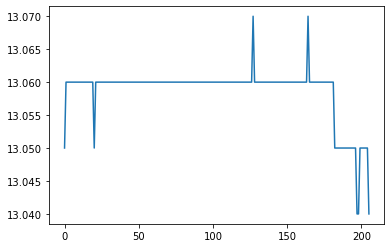

In [10]:
df_e5.value.plot(x='recorded_at', y='value')

## Modeling original data

In [11]:
class ModelEvaluation:
    def __init__(self, model_constructor):
        self.model = model_constructor()

    def fit(self, datetime64s, values):
        self.x = normalize_datetime64s(datetime64s)
        self.values = values
        return self.model.fit(
            self.x.reshape(-1, 1),
            self.values.reshape(-1, 1)
        )

    def loss(self):
        self.predicted = self.model.predict(self.x.reshape(-1, 1))
        self.mse = mean_squared_error(
            self.values,
            self.model.predict(self.x.reshape(-1, 1))
        )
        return self.mse

    def plot(self, comparison=None):
        data = {
            'x': self.x,
            'predicted': self.predicted.reshape(1, -1)[0],
            'actual': self.values,
        }
        if comparison is not None:
            data['comparison'] = comparison.reshape(1, -1)[0]
        pd.DataFrame(data=data).plot(x='x')

### Ridge

In [12]:
ev_r = ModelEvaluation(Ridge)
ev_r.fit(df_e5.recorded_at.values, df_e5.value.values)

Ridge()

In [13]:
ev_r.loss()

1.1010209770044376e-05

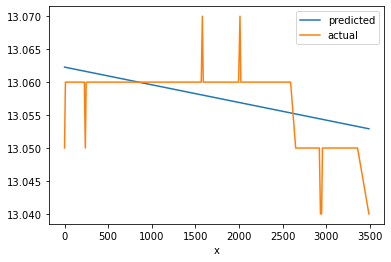

In [14]:
ev_r.plot()

### Poly Ridge

In [15]:
def poly_ridge():
    degree = 3
    return make_pipeline(PolynomialFeatures(degree), Ridge())

In [16]:
ev_pr = ModelEvaluation(poly_ridge)
ev_pr.fit(df_e5.recorded_at.values, df_e5.value.values)

/Users/gua/local/mambaforge/envs/my-little-ruuvi-setup/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:156: LinAlgWarning: Ill-conditioned matrix (rcond=7.23887e-23): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True, overwrite_a=True).T


Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('ridge', Ridge())])

In [17]:
ev_pr.loss()

4.414958156149085e-06

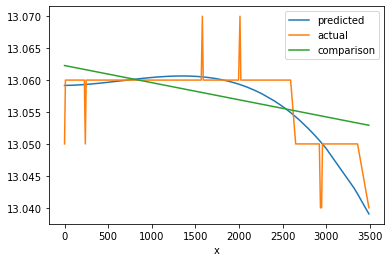

In [18]:
ev_pr.plot(comparison=ev_r.predicted)

### Interpolation 

In [19]:
class Interpolation:
    def fit(self, datetime64s, values):
        self.x = normalize_datetime64s(datetime64s)
        self.values = values
        self.interpolator = interp1d(self.x, self.values)
        return self.interpolator

    def loss(self):
        self.predicted = self.interpolator(self.x.reshape(-1, 1))
        self.mse = mean_squared_error(
            self.values,
            self.predicted
        )
        return self.mse

    def plot(self, comparison=None):
        data = {
            'x': self.x,
            'predicted': self.predicted.reshape(1, -1)[0],
            'actual': self.values,
        }
        if comparison is not None:
            data['comparison'] = comparison.reshape(1, -1)[0]
        pd.DataFrame(data=data).plot(x='x')

In [20]:
i = Interpolation()
i.fit(df_e5.recorded_at.values, df_e5.value.values)

In [21]:
i.loss()

0.0

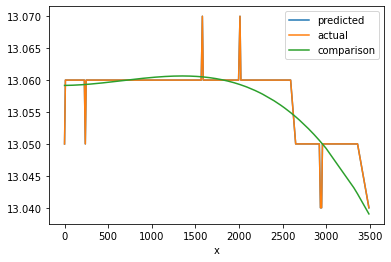

In [22]:
i.plot(comparison=ev_pr.predicted)

## First, last, min, max

In [23]:
df_e5.value.idxmin(), df_e5.value.idxmax()

(197, 127)

In [24]:
keep_idx = sorted(list(set([0, df_e5.count()[0] - 1, df_e5.value.idxmin(), df_e5.value.idxmax()])))
keep_idx

[0, 127, 197, 205]

In [25]:
df_e5.loc[keep_idx]

,index,recorded_at,sensor,value
0,2345798,2021-12-01 16:00:01,E50490B330D9,13.05
127,2346346,2021-12-01 16:26:20,E50490B330D9,13.07
197,2346695,2021-12-01 16:48:53,E50490B330D9,13.04
205,2346780,2021-12-01 16:58:08,E50490B330D9,13.04


<AxesSubplot:xlabel='recorded_at'>

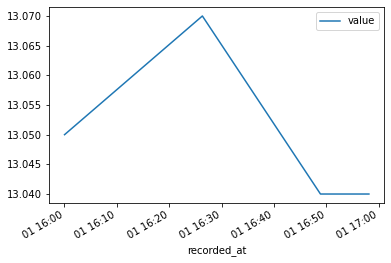

In [26]:
df_e5.loc[keep_idx].plot(x='recorded_at', y='value')

## Interp, minmax

In [27]:
i_0 = Interpolation()
i_0.fit(df_e5.loc[keep_idx].recorded_at.values, df_e5.loc[keep_idx].value.values)

<AxesSubplot:xlabel='x'>

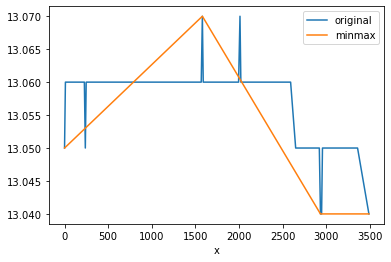

In [28]:
xs = normalize_datetime64s(df_e5.recorded_at.values)
pd.DataFrame(data={
    'x': xs,
    'original': i.interpolator(xs),
    'minmax': i_0.interpolator(xs),
}).plot(x='x')

In [29]:
mean_squared_error(
    i.interpolator(xs),
    i_0.interpolator(xs)
)

3.618979350971755e-05

## Simplifier evaluation

In [30]:
class SimplifierEvaluation:
    def __init__(self, simplifier):
        self.simplifier = simplifier

    def fit(self, datetime64s, values, **kwargs):
        self.x = normalize_datetime64s(datetime64s)
        self.values = values
        self.x_s, self.values_s = self.simplifier(self.x, values, **kwargs)
        self.interpolator = interp1d(self.x, self.values)
        self.interpolator_s = interp1d(self.x_s, self.values_s)

    def loss(self):
        return mean_squared_error(
            self.interpolator(self.x),
            self.interpolator_s(self.x)
        )

    def ratio(self):
        return float(len(self.values_s)) / float(len(self.values))

    def plot(self):
        xs = normalize_datetime64s(df_e5.recorded_at.values)
        pd.DataFrame(data={
            'x': xs,
            'original': self.interpolator(self.x),
            'simplified': self.interpolator_s(self.x),
        }).plot(x='x')

### First, last, min, max 

In [31]:
def first_last_min_max(x, y):
    keep_idx = sorted(list(set([0, len(x) - 1, np.argmin(y), np.argmax(y)])))
    return (x[keep_idx], y[keep_idx])

In [32]:
s = SimplifierEvaluation(first_last_min_max)

In [33]:
s.fit(df_e5.recorded_at, df_e5.value)

In [34]:
s.loss(), s.ratio()

(3.618979350971755e-05, 0.019417475728155338)

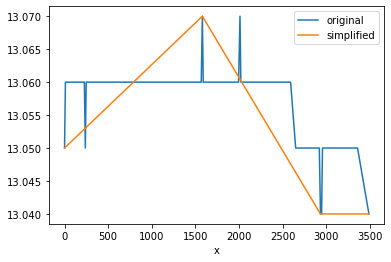

In [35]:
s.plot()

### Remove intermediates

In [36]:
def remove_intermediates(x, y):
    remove_indices = []
    for w in window(enumerate(zip(x, y)), 3):
        x0, y0 = w[0][1]
        x1, y1 = w[1][1]
        x2, y2 = w[2][1]
        if y0 == y1 and y1 == y2:
            remove_indices.append(w[1][0])
    keep_idxs = set(list(range(len(x)))) - set(remove_indices)
    return x[keep_idxs], y[keep_idxs]

In [37]:
s = SimplifierEvaluation(remove_intermediates)

In [38]:
s.fit(df_e5.recorded_at, df_e5.value)

In [39]:
s.loss(), s.ratio()

(0.0, 0.09223300970873786)

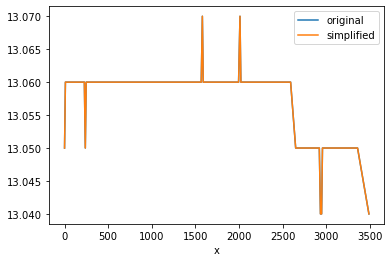

In [40]:
s.plot()

### Remove intermediates fuzzy

In [41]:
def remove_intermediates_fuzzy(x, y, allowed_delta=0.01):
    remove_indices = []
    for w in window(enumerate(zip(x, y)), 3):
        x0, y0 = w[0][1]
        x1, y1 = w[1][1]
        x2, y2 = w[2][1]

        prop_x = (x1 - x0) / (x2 - x0)
        d_y = y2 - y0
        derived = y0 + prop_x * d_y
        delta = abs((abs(derived) - abs(y1)) / max(abs(y0), abs(y1), abs(y2)))

        if abs(delta) < allowed_delta:
            remove_indices.append(w[1][0])

    keep_idxs = (set(list(range(len(x)))) - set(remove_indices)) | set([np.argmin(y), np.argmax(y)])
    return x[keep_idxs], y[keep_idxs]

In [42]:
remove_intermediates_fuzzy(pd.Series([1, 2, 3, 4]), pd.Series([1001, 1003.2, 1005, 1007]), allowed_delta=0.0001)

(0    1
 1    2
 3    4
 dtype: int64,
 0    1001.0
 1    1003.2
 3    1007.0
 dtype: float64)

In [43]:
s = SimplifierEvaluation(remove_intermediates_fuzzy)

In [44]:
s.fit(df_e5.recorded_at, df_e5.value, allowed_delta=0.005)

In [45]:
s.loss(), s.ratio()

(3.618979350971755e-05, 0.019417475728155338)

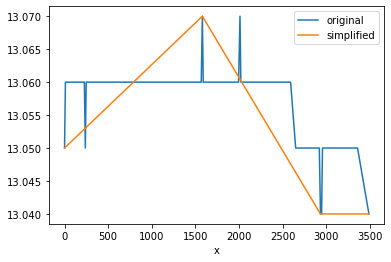

In [46]:
s.plot()

#### Test on more data

In [47]:
def analyze_simplification(df, simplifier, **kwargs):
    df['recorded_at_dt'] = pd.to_datetime(df.recorded_at)

    gb = df.groupby([
        df.sensor,
        df.recorded_at_dt.dt.month,
        df.recorded_at_dt.dt.day,
        df.recorded_at_dt.dt.hour
    ])
    
    losses, ratios = [], []
    for key, item in gb:
        s = SimplifierEvaluation(simplifier)
        if len(item) < 3:
            continue
            
        i2 = item.reset_index()
        s.fit(i2.recorded_at, i2.value, **kwargs)
        losses.append(s.loss())
        ratios.append(s.ratio())

    plt.figure(figsize=(12, 3))
    plt.subplot(1, 2, 1)
    plt.hist(losses, bins=13)
    plt.subplot(1, 2, 2)
    plt.hist(ratios, bins=13)

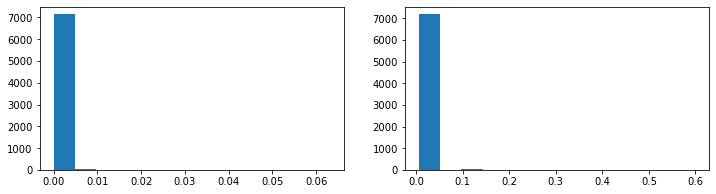

In [48]:
analyze_simplification(df, remove_intermediates_fuzzy)

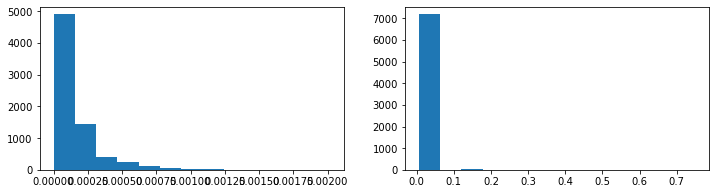

In [49]:
analyze_simplification(df_battery_voltage, remove_intermediates_fuzzy)

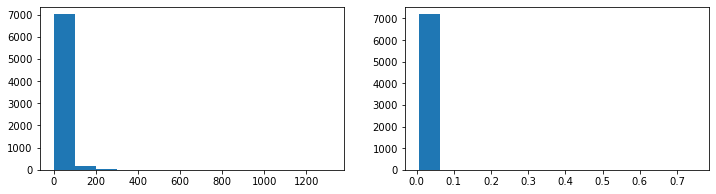

In [50]:
analyze_simplification(df_pressure, remove_intermediates_fuzzy, allowed_delta=0.01)

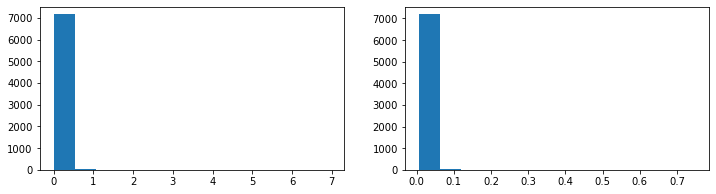

In [51]:
analyze_simplification(df_humidity, remove_intermediates_fuzzy, allowed_delta=0.01)